# Introduction

Predict in-game rating using several predictors

We will also determine significant predictors & assess model accuracy

# Import

## Library

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm 

# Calculate multicollinearity
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Scale predictors
from sklearn.preprocessing import StandardScaler

# Split data set
from sklearn.model_selection import train_test_split

# Regression Model
from sklearn.linear_model import LinearRegression

# Calculate  lowest Train MSE, Test MSE & r-squared
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score


## Data 

Read in CSV

In [209]:
df = pd.read_csv("/Users/nick/work/python/fc_25/fc_25.csv")

Preview

In [210]:
pd.set_option("display.max_columns", df.shape[1])

print(df.info())

df.loc[0:5]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16161 entries, 0 to 16160
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       16161 non-null  object
 1   Rating     16161 non-null  int64 
 2   Pace       16161 non-null  int64 
 3   Shooting   16161 non-null  int64 
 4   Passing    16161 non-null  int64 
 5   Dribbling  16161 non-null  int64 
 6   Defense    16161 non-null  int64 
 7   Physical   16161 non-null  int64 
 8   Vision     16161 non-null  int64 
 9   Reflex     16161 non-null  int64 
 10  Composure  16161 non-null  int64 
 11  Jumping    16161 non-null  int64 
 12  Foot       16161 non-null  object
 13  Age        16161 non-null  int64 
dtypes: int64(12), object(2)
memory usage: 1.7+ MB
None


,Name,Rating,Pace,Shooting,Passing,Dribbling,Defense,Physical,Vision,Reflex,Composure,Jumping,Foot,Age
0,Kylian Mbappé,91,97,90,80,92,36,78,83,93,88,88,Right,25
1,Rodri,91,66,80,86,84,87,85,84,93,94,83,Right,28
2,Erling Haaland,91,88,92,70,81,45,88,74,94,87,92,Left,24
3,Jude Bellingham,90,80,87,83,88,78,83,90,91,87,84,Right,21
4,Vini Jr.,90,95,84,81,91,29,69,85,86,83,74,Right,24
5,Kevin De Bruyne,90,67,87,94,87,65,78,95,92,88,71,Right,33


# Clean & Modify Data

Drop "Name", not necessary in our analysis

In [211]:
df = df.drop(columns=["Name"])

Lowercase Column & Values

In [212]:
# change all column to lower case 
df.columns  = df.columns.str.lower()

# lower case all values
df = df.apply(lambda value: value.str.lower() if (value.dtype == "object") else value)

Check for duplicated rows & missing data in columns

In [213]:
print("There are", df.duplicated().sum(), "duplicated rows")
print("no. of missing data in each column:\n",df.isna().sum())

There are 0 duplicated rows
no. of missing data in each column:
 rating       0
pace         0
shooting     0
passing      0
dribbling    0
defense      0
physical     0
vision       0
reflex       0
composure    0
jumping      0
foot         0
age          0
dtype: int64


# Regression Analysis

## Simple 

Correlation of each variable to target variable ("rating")

In [214]:
# Check correlation of each predictor
correlation_df = df.select_dtypes(include=['number'])
correlation_with_target = correlation_df.corr()['rating'].drop('rating')

print(round(correlation_with_target,2).sort_values(ascending=False))

reflex       0.88
passing      0.71
dribbling    0.69
composure    0.68
physical     0.56
jumping      0.56
vision       0.53
shooting     0.46
age          0.39
defense      0.36
pace         0.27
Name: rating, dtype: float64


“reflex” have a strong positive relationship with "rating". 

It will be our predictor in simple linear regression.

Setting Target & Predictor variable

In [215]:
target = df[["rating"]]
predictor = df[["reflex"]]

Split data set 70:30 train-test

In [216]:
predictor_train, predictor_test, target_train, target_test = train_test_split(predictor, target, test_size=0.3, random_state=42)
print("train set have",predictor_train.shape[0],"rows for training")
print("test set have",predictor_test.shape[0],"rows for evaluating model performance")

train set have 11312 rows for training
test set have 4849 rows for evaluating model performance


Train model

In [217]:
simple_linear = LinearRegression()

# Fit training data
simple_linear.fit(predictor_train,target_train)

# Best fit line (Lowest train MSE) 
line = simple_linear.predict(predictor_train)
slope = simple_linear.coef_.flatten()[0]
intercept = simple_linear.intercept_.flatten()[0]

Test Data

In [218]:
predicted_target = simple_linear.predict(predictor_test)

Plot

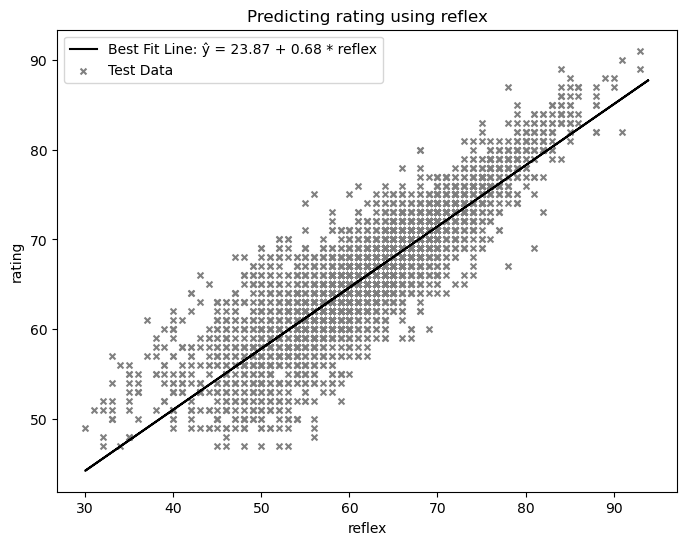

In [219]:
# Plot the figure
plt.figure(figsize=(8, 6))

# Plot line
plt.plot(predictor_train, line, color='black', label=f'Best Fit Line: ŷ = {intercept:.2f} + {slope:.2f} * reflex')


# Plot test data 
plt.scatter(predictor_test, target_test, color='grey',s=18, marker='x', label='Test Data')

# Adding labels and title
plt.xlabel('reflex')  
plt.ylabel('rating')  
plt.title('Predicting rating using reflex')
plt.legend()

plt.show()


The best-fit line runs through approximately linear test data points.

When reflex increases by a unit, rating increases by 0.68.


P-Value of reflex

In [220]:
# Calculate p-value
predictor_constant = sm.add_constant(predictor)
stats_model = sm.OLS(target,predictor_constant).fit()

# Extract and format p-values
p_values = round(stats_model.pvalues.drop("const"), 2).sort_values(ascending=False)
p_values_df = pd.DataFrame(p_values).reset_index()
p_values_df.columns = ['Predictor', 'P-Value']


print("P-values for predictors:")
print(p_values_df.to_string(index=False))


P-values for predictors:
Predictor  P-Value
   reflex      0.0


“reflex” is a significant predictor, p-value is (<0.05).

Summary (MSE & R-Squared)

In [221]:

# Calculate MSE 
train_mse = round(mean_squared_error(target_train, line), 2)
test_mse = round(mean_squared_error(target_test, predicted_target), 2)

# Calculate R-squared
r_squared = round(r2_score(target_test, predicted_target), 2)

# Create summary table
summary_df = pd.DataFrame({
    'Metric': ['Train MSE', 'Test MSE', 'R-squared'],
    'Value': [train_mse, test_mse, r_squared]
})


print(summary_df.to_string(index=False))

   Metric  Value
Train MSE  10.48
 Test MSE  10.86
R-squared   0.77


Train MSE is slightly lower than Test MSE, the model fits well.

R² (0.77), 23% of the variability in “rating” cannot be explained by “reflex”


## Multiple

Dummy variable for "foot"

In [222]:
# Create  dummy
df = pd.get_dummies(df, columns=["foot"], drop_first=True)

# Change "True"/"False" value to "1"/"0"
df["foot_right"] = df["foot_right"].astype(int)

Multiple regression analysis only involves numerical predictors.

Set target and initial predictors 

In [223]:
target = df[["rating"]]
predictors_raw =df[[ 'pace', 'shooting', 'passing', 'dribbling', 'defense','physical', 
                     'vision', 'reflex','composure', 'jumping',  'age', 
                    'foot_right']]

Collinearity

In [224]:
# Add constant 
predictors_constant = add_constant(predictors_raw)

# Calculate VIF predictor
vif_data = pd.DataFrame()
vif_data['predictors'] = predictors_constant.columns
vif_data['vif'] = [variance_inflation_factor(predictors_constant, i) for i in range(predictors_constant.shape[1])]
vif_data = vif_data[vif_data['predictors'] != 'const']

print(round(vif_data,2).sort_values(by="vif",ascending=False))

    predictors   vif
4    dribbling  8.09
3      passing  6.99
2     shooting  5.33
10     jumping  4.06
6     physical  4.02
7       vision  3.71
5      defense  3.65
9    composure  3.54
8       reflex  3.40
1         pace  1.96
11         age  1.44
12  foot_right  1.03


When there are highly correlated predictors, it affects model interpretability

Predictors with VIF > 5 signifies high collinearity.

We remove them from final predictors.


Finalize predictors (remove dribbling, passing, shooting)

In [225]:
predictors = df[[ 'pace',  'defense','physical',  'vision',  'reflex',
                 'composure', 'jumping',  'age',  'foot_right']]

Scale Predictors

In [226]:
scaler = StandardScaler()
# scale data
predictors_scaled = scaler.fit_transform(predictors)


predictors_scaled = pd.DataFrame(predictors_scaled, columns=predictors.columns)

We standard transform predictors such that they are on a similar scale.

It is now easier to interpret coefficients.


Split data set 70:30 train-test

In [227]:
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors_scaled, target, test_size=0.3, random_state=20)
print("train set have",predictors_train.shape[0],"rows for training")
print("test set have",predictors_test.shape[0],"rows for evaluating model performance")

train set have 11312 rows for training
test set have 4849 rows for evaluating model performance


Train model

In [228]:
multiple_linear = LinearRegression()

# Fit training data
multiple_linear.fit(predictors_train,target_train)

# Best fit line (Lowest train MSE) 
m_line = multiple_linear.predict(predictors_train)
coefficients = multiple_linear.coef_
intercept = multiple_linear.intercept_


# Coefficients
coef_df = pd.DataFrame({
    'Predictor': predictors.columns,  
    'Coefficient': coefficients.flatten()  
})

intercept_df = pd.DataFrame({'Predictor': ['Intercept'], 'Coefficient': [intercept]})
coef_df = pd.concat([coef_df, intercept_df], ignore_index=True)


print(coef_df)

    Predictor          Coefficient
0        pace             0.983269
1     defense             -0.09938
2    physical             1.273626
3      vision             0.198704
4      reflex             4.413041
5   composure             0.771968
6     jumping            -0.166833
7         age             0.428675
8  foot_right            -0.129122
9   Intercept  [66.13900236678629]


Test model

In [229]:
predicted_target = multiple_linear.predict(predictors_test)

P-Value

In [230]:
# Calculate p-value
predictors_constant = sm.add_constant(predictors)
stats_model = sm.OLS(target,predictors_constant).fit()


p_values = round(stats_model.pvalues.drop("const"), 2).sort_values(ascending=False)


p_values_df = pd.DataFrame(p_values).reset_index()
p_values_df.columns = ['Predictor', 'P-Value']


print("P-values for predictors:")
print(p_values_df.to_string(index=False))


P-values for predictors:
 Predictor  P-Value
      pace      0.0
   defense      0.0
  physical      0.0
    vision      0.0
    reflex      0.0
 composure      0.0
   jumping      0.0
       age      0.0
foot_right      0.0


All predictors are significant (p-value <0.05)


In [231]:
# Calculate train  & test mse
train_mse = round(mean_squared_error(target_train, m_line), 2)
test_mse = round(mean_squared_error(target_test, predicted_target), 2)

# Calculate R-squared
r_squared = round(r2_score(target_test, predicted_target), 2)
adj_r_squared = round(1 - (1 - r_squared) * (len(target_test) - 1) / (len(target_test) - predicted_target.shape[1] - 1), 2)

# Create summary table
summary_df = pd.DataFrame({
    'Metric': ['Train MSE', 'Test MSE', 'R-squared', 'Adjusted R-squared'],
    'Value': [train_mse, test_mse, r_squared, adj_r_squared]
})

# Print summary table
print(summary_df.to_string(index=False))

            Metric  Value
         Train MSE   8.33
          Test MSE   8.48
         R-squared   0.81
Adjusted R-squared   0.81


Train MSE (8.12) is slightly lower than Test MSE (8.22), the model fits well.

Adjusted R² (0.82), 18% of the variability in "rating" cannot be explained by the predictors


# Conclusion

The multiple regression model can predict rating fairly well.

It was a surprise to see dribbling, passing, shooting removed from the model.

Reflex provide a good gauge of a player's rating